In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path

%load_ext rpy2.ipython

In [2]:
df = pd.read_csv(Path("data/edgeR_table_annotated.csv"), index_col=0)
df.set_index(["ENSG", "Symbol", "Entrez"], inplace=True)
df.head()

,,,logFC,logCPM,F,PValue,FDR,DDR_Process
ENSG,Symbol,Entrez,,,,,,
ENSG00000075213,SEMA3A,10371.0,-4.162525,5.563056,2754.240211,2.791564e-17,4.057315e-13,NaN
ENSG00000180530,NRIP1,8204.0,-11.196477,4.761525,2461.417400,6.037401e-17,4.057315e-13,NaN
ENSG00000171617,ENC1,8507.0,-3.559044,5.827456,2435.864607,6.485478e-17,4.057315e-13,NaN
ENSG00000280441,NaN,NaN,-3.345196,5.870778,1278.556071,5.348713e-15,2.509616e-11,NaN
ENSG00000163762,TM4SF18,116441.0,4.653469,4.448282,1205.048468,8.012527e-15,3.007582e-11,NaN


In [3]:
FDR = 0.01

ddr_tab = df[~df["DDR_Process"].isna()]
DEG = ddr_tab[ddr_tab["FDR"] < FDR]
top_DEG = DEG.sort_values(by="FDR").index.get_level_values(level="Symbol").to_list()
top_DEG = [t for t in top_DEG if str(t) != "nan"]
top_DEG = ddr_tab.loc[ddr_tab.index.get_level_values("Symbol").isin(top_DEG)].sort_values(by="logFC").index.get_level_values("Symbol").to_list()
len(top_DEG)

26

In [4]:
%%R -o ycounts_rows

loaded_object <- readRDS("data/edger_table.rds")
result <- loaded_object$result
y <- loaded_object$y  # dispersions
ycounts_rows <- rownames(y$counts)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma



In [5]:
ind = pd.Index(ycounts_rows)
symbols = df.loc[ind].index.get_level_values(level="Symbol").to_list()

In [6]:
%%R -i top_DEG,symbols -o logCPM

library(edgeR)

logCPM <- cpm(y, prior.count=2, log=TRUE)

rownames(logCPM) <- symbols

colnames(logCPM) <- rownames(y$samples)
logCPM <- logCPM[rownames(logCPM) %in% top_DEG, ]

dummy <- data.frame(1:length(top_DEG))
rownames(dummy) <- top_DEG
logCPM <- logCPM[match(rownames(dummy), rownames(logCPM)),]

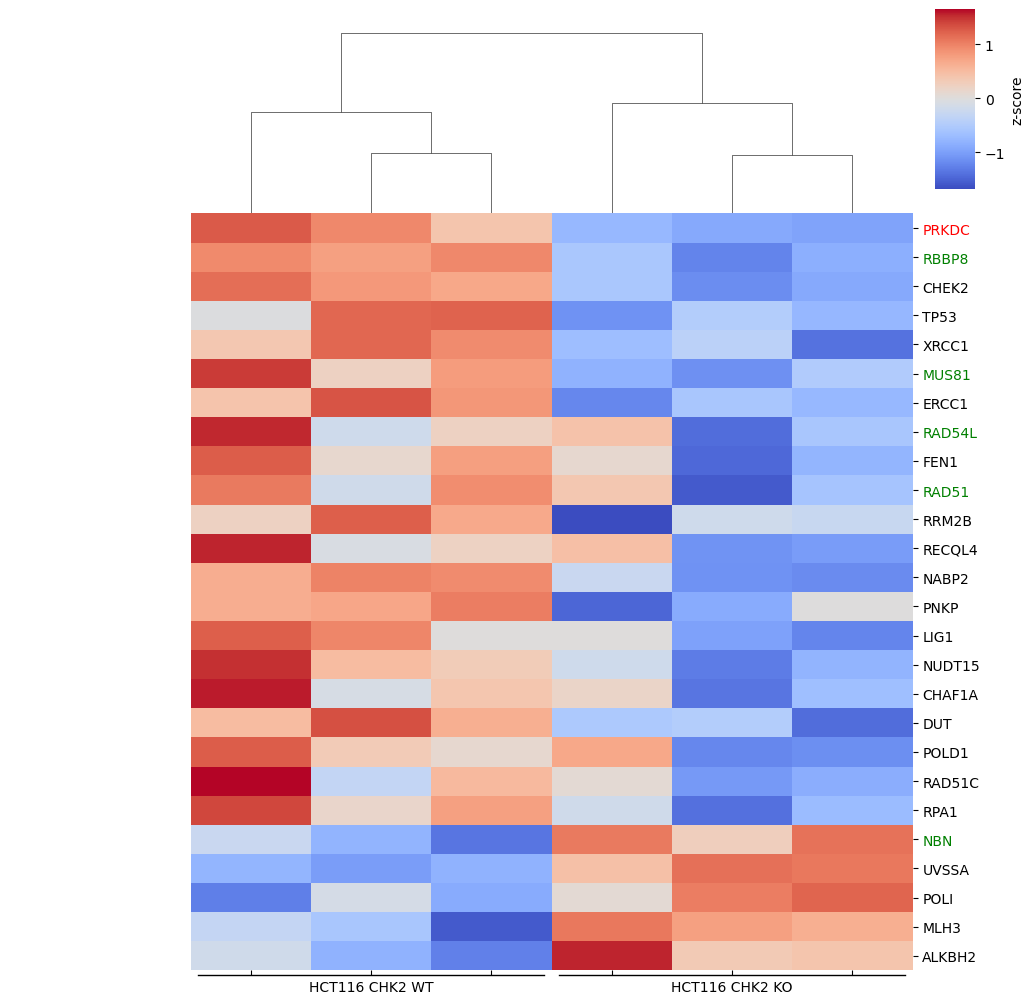

In [10]:
logCPM_df = pd.DataFrame(logCPM, index=top_DEG, 
                         columns=["CHK2 WT","CHK2 WT","CHK2 WT","CHK2 KO","CHK2 KO","CHK2 KO"])

cbar_kws = dict(label="z-score", ticks=[-1,0,1])

g = sns.clustermap(logCPM_df, z_score=0, figsize=(10,10), row_cluster=False, cmap="coolwarm", 
                   cbar_kws=cbar_kws,
                   cbar_pos=(0.94, 0.82, 0.04, 0.18))

# Customize y-axis tick labels
green_labels = ["RBBP8","MUS81","RAD54L","NBN","RAD51"]
for label in g.ax_heatmap.get_yticklabels():
    if label.get_text() in green_labels:
        label.set_color('green')
    elif label.get_text() == "PRKDC":
        label.set_color("red")


def labelxtext(i):
    if i == 1:
        return "HCT116 CHK2 WT"
    elif i == 4:
        return "HCT116 CHK2 KO"
    else:
        return None

g.ax_heatmap.set_xticklabels(
    [labelxtext(i) for i in range(len(g.ax_heatmap.get_xticklabels()))]
)

#g.figure.axes[2].axhline(n_top_genes+0.5, zorder=99, lw=3, color="black")

ax = g.ax_heatmap

# Get axis position in figure coordinates
bbox = ax.get_position()

# Create a new axes on top of the xticklabels area
line_ax = g.figure.add_axes([bbox.x0, bbox.y0-0.01, bbox.width, 0.01])  # [left, bottom, width, height]

line_ax.plot([0.01, 0.49], [0.5, 0.5], color='black', linewidth=1, transform=line_ax.transAxes)
line_ax.plot([0.51, 0.99], [0.5, 0.5], color='black', linewidth=1, transform=line_ax.transAxes)
line_ax.axis('off')

g.figure.savefig(f"figures/ddr_heatmap.pdf", bbox_inches="tight")